# **DIVE INTO CODE COURSE**
## **Sprint Deep Learning - Convolution Neural Network 2D**
**Student Name**: Doan Anh Tien<br>
**Student ID**: 1852789<br>
**Email**: tien.doan.g0pr0@hcmut.edu.vn

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
import random
from math import log2
from sklearn.metrics import accuracy_score

plt.style.use('ggplot')

### **[Problem 1] Creating a 2-D convolutional layer**

### **Support class and functions**

In [37]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
#         self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        self._stop = int(np.ceil(X.shape[0]/self.batch_size))
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [38]:
def cross_entropy_error(y, Z3):

    DELTA = 1e-7
    batch_size = y.shape[0]
    return -np.sum(y * np.log(Z3 + DELTA))/batch_size

class SimpleInitializer:

    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, *shape):

        w = self.sigma * np.random.randn(*shape)
        return w

    def B(self, *shape):

        b = np.zeros(*shape)
        return b

    def B_zeros(self, *shape):

        b = np.zeros(*shape)
        return b

class Tanh:

    def forward(self, A):
        self.A = A
        return np.tanh(A)

    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)


class Softmax:

    def __init__(self):
        self.loss = None

    def forward(self, X):

        X = X.T
        y = np.exp(X) / np.sum(np.exp(X), axis=0)

        return y.T

    def backward(self, Z3, y):
        batch_size = y.shape[0]
        ret = (Z3 - y)/batch_size

        self.loss = cross_entropy_error(y, Z3)

        return ret


class ReLU:

    def __init__(self):
        self.x = None

    def forward(self, X):

        self.x = X

        return np.maximum(0, X)

    def backward(self, X):

        return np.where(self.x > 0, X, 0)


class XavierInitializer:

    def __init__(self, sigma):
        _ = sigma

    def W(self, n_nodes1, n_nodes2):

        sigma = 1.0 / np.sqrt(n_nodes1)
        w = sigma * np.random.randn(n_nodes1, n_nodes2)
        return w

    def B(self, n_nodes2):

        b = np.random.randn(n_nodes2)
        return b

class HeInitializer:

    def __init__(self, sigma):
        _ = sigma

    def W(self, n_nodes1, n_nodes2):

        sigma = np.sqrt( 2.0 / n_nodes1)
        w = sigma * np.random.randn(n_nodes1, n_nodes2)
        return w

    def B(self, n_nodes2):

        b = np.random.randn(n_nodes2)
        return b    
    
    
class AdaGrad:

    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1

    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB
    
class SGD:

    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

### **2D Convolution Layer**

In [39]:
def im2col(in_data, FH, FW, stride, padding):
    """
    Parameters
    ----------
    in_data: Input data consisting of a 4-dimensional array of (number of data, number of channels, height, width)
    FH: Filter size in height
    FW: Filter size in width
    stride: Stride size
    padding: Number of padding

    Returns
    -------
    col: 2D ndarray
    """
    N, C, H, W = in_data.shape
    OH, OW = output_size_calculation(H, W, FH, FW, stride, padding)
    img = np.pad(in_data, [(0,0), (0,0), (padding, padding), (padding, padding)], 'constant')
    col = np.zeros([OH*OW*N, C*FH*FW])

    idx = 0
    for n in range(N):
        for ch in range(C):
            for i in range(OH):
                for j in range(OW):
                    patch = img[n, ch, i*stride:i*stride+FH, j*stride:j*stride+FW]
                    col[idx, :] = patch.reshape(-1)
                    idx += 1

    return col

def col2im(col, in_shape, FH, FW, stride, padding):
    """
    Parameters
    ----------
    col: 2D ndarray
    FH: Filter size in height
    FW: Filter size in width
    stride: Stride size
    padding: Number of padding

    Returns
    -------
    img: Input data consisting of a 4-dimensional array of (number of data, number of channels, height, width)
    """
    N, C, H, W = in_shape
    OH, OW = output_size_calculation(H, W, FH, FW, stride, padding)
    img = np.zeros((N, C, H + 2*padding + stride - 1, W + 2*padding + stride - 1))

    idx = 0
    for n in range(N):
        for ch in range(C):
            for i in range(OH):
                for j in range(OW):
                    _col = col[idx, :].reshape(FH, FW)
                    img[n, ch, i*stride:i*stride+FH, j*stride:j*stride+FW] += _col
                    idx += 1

    return img[:, :, padding:H + padding, padding:W + padding]


class Conv2d:
    """
    2D Convolution Layer
    Parameters
    ----------
    FN：Number of filters
    C：Number of channels ("C"hannel)
    FH：Filter size in height
    FW：Filter size in width
    stride: Stride size
    padding: Number of padding
    initializer: The type of initializer
    optimizer: The optimization method
    """
    def __init__(self, FN, C, FH, FW, stride, padding=0, optimizer=SGD, initializer=SimpleInitializer):

        self.stride = stride
        self.padding = padding

        self.optimizer = optimizer
        self.initializer = initializer

        self.W = self.initializer.W(FN, C, FH, FW)
        self.B = self.initializer.B_zeros(FN)

        self.dW = None
        self.dB = None

        self.x = None
        self.col = None
        self.col_W = None

    def forward(self, X):

        self.x = X

        N, C, H, W = X.shape
        FN, C, FH, FW = self.W.shape
        OH, OW = output_size_calculation(H, W, FH, FW, self.stride, self.padding)

        self.col = col = im2col(X, FH, FW, self.stride, self.padding)
        self.col_W = col_W = self.W.reshape(FN, -1).T
        A = np.dot(col, col_W) + self.B
        A = A.reshape(N, OH, OW, -1).transpose(0, 3, 1, 2)

        return A

    def backward(self, dA):

        FN, C, FH, FW = self.W.shape

        self.dW = np.dot(dA.reshape(FN, -1), self.col)
        self.dW = self.dW.reshape(C, FN, FH, FW).transpose(1, 0, 2, 3)
        self.dB = np.sum(dA.reshape(FN, -1), axis=1)

        col_dX = np.dot(self.col_W, dA.reshape(FN, -1))
        dX = col2im(col_dX.T, self.x.shape, FH, FW, self.stride, self.padding)

        self = self.optimizer.update(self)

        return dX

### **[Problem 2] Experiments with 2D convolutional layers on small arrays**

In [40]:
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])
# (2,3,3)
w = np.array([[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]],
              [[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]])

w = w[:, np.newaxis, : :]

In [41]:
conv = Conv2d(FN=2, C=1, FH=3, FW=3, stride=1, padding=0, optimizer=SGD(0.05), initializer=SimpleInitializer(0.01))
conv.W = w
A = conv.forward(x)
print(A)

[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]


In [42]:
delta = np.array([[[ -4,  -4],
                   [ 10,  11]],
                  [[  1,  -7],
                   [  1, -11]]])

dZ = conv.backward(delta)

print(dZ)

[[[[  0.   0.   0.   0.]
   [  0.  -5.   4.  -7.]
   [  0.  13.  27. -11.]
   [  0. -10. -11.   0.]]]]


With padding = 1

In [43]:
conv.padding = 0

In [44]:
dZ = conv.backward(delta)

print(dZ)

[[[[  24.5    22.8    23.2   -11.1 ]
   [ -10.2  -132.5  -144.75 -159.9 ]
   [ -19.4  -199.5  -206.75 -239.7 ]
   [ -93.9  -335.1  -357.75 -257.4 ]]]]


### **[Problem 3] Output size after 2-dimensional convolution**

In [45]:
def output_size_calculation(H, W, FH, FW, stride, padding):
      """
      Function to return the output size of features
      Parameters
      ----------
      H: Input size in height
      W: Input size in width
      FH：Filter size in height
      FW：Filter size in width
      stride: Stride size
      padding: Number of padding

      Returns
      ----------
      OH: int
          Output size in height
      OW: int
          Output size in width
      """

      OH = (H + 2*padding - FH)/stride + 1
      OW = (W + 2*padding - FW)/stride + 1
      
      return int(OH), int(OW)

### **[Problem 4] Creation of maximum pooling layer**

In [46]:
class MaxPool2D:
    """
    Parameters
     pooling_H：Pooling size in height
     pooling_W：Pooling size in width
     stride：Stride size
     padding：Number of padding
    ----------
    """
    def __init__(self, pooling_H, pooling_W, stride, padding=0):
        self.pooling_H = pooling_H
        self.pooling_W = pooling_W
        self.stride = stride
        self.padding = padding

        self.x = None
        self.argmax_col = None 

    def forward(self, X):

        self.x = X  

        N, C, H, W = X.shape    
        OH, OW = output_size_calculation(H, W, self.pooling_H, self.pooling_W, self.stride, self.padding)

        col = im2col(X, self.pooling_H, self.pooling_W, self.stride, self.padding)
        col = col.reshape(-1, self.pooling_H*self.pooling_W)
        self.argmax_col = col.argmax(axis=1)
        A = col.max(axis=1)

        return A.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)

    def backward(self, dA):

        dout = dA.transpose(0, 2, 3, 1)

        pool_size = self.pooling_H * self.pooling_W
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.argmax_col.size), self.argmax_col.reshape(-1)] = dout.reshape(-1)
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dZ = col2im(dcol, self.x.shape, self.pooling_H, self.pooling_W, self.stride, self.padding)

        return dZ

In [47]:
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print("X")
print(X)

Pooling = MaxPool2D(2, 2, 2, 0)
A = Pooling.forward(X)
print("A")
print(A)

dA = np.random.randint(0,9,9).reshape(A.shape)
print("-dA")
print(dA)

dZ = Pooling.backward(dA)
print("dZ")
print(dZ)

X
[[[[6 0 0 5 6 2]
   [2 1 2 5 1 5]
   [5 0 5 1 5 8]
   [6 2 4 0 6 6]
   [3 1 3 4 4 7]
   [3 5 7 4 5 6]]]]
A
[[[[6. 5. 6.]
   [6. 5. 8.]
   [5. 7. 7.]]]]
-dA
[[[[4 2 2]
   [3 1 4]
   [0 3 4]]]]
dZ
[[[[4. 0. 0. 2. 2. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 1. 0. 0. 4.]
   [3. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 4.]
   [0. 0. 3. 0. 0. 0.]]]]


### **[Problem 6] Smoothing**

In [48]:
class Flatten:
    '''
    Flatten layer
    '''
    def __init__(self):

        self.x_shape = None

    def forward(self, X):

        self.x_shape = X.shape
        flatten_x = X.reshape(len(X), -1)

        return flatten_x

    def backward(self, dA):
        return dA.reshape(self.x_shape)

### **[Problem 7] Learning and estimation**

**Dataset Preparation**

In [49]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [50]:
print(X_train.shape) # (60000, 28, 28)
print(y_train.shape) # (10000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(y_test.shape)
print(X_train[0].dtype) # uint8

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
uint8


**Visualization**

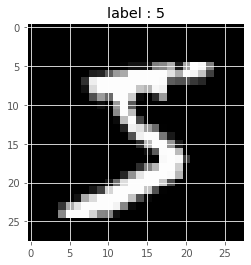

In [51]:
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

**Preprocessing**

In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist
from sklearn.metrics import accuracy_score

In [53]:
X_train = X_train / 255.0
X_test = X_test / 255.0

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

(48000, 28, 28)
(10000, 28, 28)


**Neural Network Class**

In [54]:
class FullyC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: object
      Instance of initialization method
    optimizer: object
      Instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2

        self.initializer = initializer

        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)

        self.dW = None
        self.dB = None

        self.x = None
        self.x_shape = None

        self.W_h = 0
        self.B_h = 0

    def forward(self, X):
        

        self.x_shape = X.shape
        _X = X.reshape(X.shape[0], -1)
        self.x = _X  
        A = np.dot(_X, self.W) + self.B
        return A

    def backward(self, dA):

        dZ = np.dot(dA, self.W.T)
        self.dW = np.dot(self.x.T, dA)
        self.dB = np.sum(dA, axis=0)

        self = self.optimizer.update(self)

        return dZ

In [68]:
class Scratch2DCNNClassifier():
    """
    Convolution neural network classifier with configurable structure
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, conv_param, epoch, batch_size, n_nodes1, n_nodes2, n_output, lr, sigma=0.01, optimizer=AdaGrad, activation=ReLU, initializer=HeInitializer, verbose=False):
        self.conv_param = conv_param
        self.batch_size = batch_size
        self.epoch = epoch
        self.n_nodes1 = n_nodes1   
        self.n_nodes2 = n_nodes2
        self.n_output = n_output  
        self.lr = lr     
        self.sigma = sigma
        self.verbose = verbose

        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        self.Conv2d = Conv2d(FN=conv_param['FN'], C=conv_param['C'], FH=conv_param['FH'],
                             FW=conv_param['FW'], stride=conv_param['stride'], padding=conv_param['padding'],
                             initializer=SimpleInitializer(self.sigma), optimizer=SGD(self.lr))
        self.flatten = Flatten()
        self.activation1 = self.activation()
        self.FC2 = FullyC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation2 = self.activation()
        self.FC3 = FullyC(self.n_nodes2, self.n_output, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation3 = Softmax()

        self.loss_list = []
        self.acc_list = []

    def fit(self, X, y, X_val=None, y_val=None):

        for p in range(self.epoch):
            if self.verbose == True:
              print("Epoch", p)
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=p)

            loss = 0
            for mini_X, mini_y in get_mini_batch:
                m_x = mini_X[:,np.newaxis,:,:]

                Z3 = self.forward(m_x)
                self.backward(m_x, mini_y, Z3)

                loss += self.activation3.loss

            self.loss_list.append(loss/len(get_mini_batch))
            self.acc_list.append(accuracy_score(self.predict(X), np.argmax(y,axis=1)))



    def forward(self, X):

        A1 = self.Conv2d.forward(X)
        Z1 = self.activation1.forward(A1)
        Z2 = self.flatten.forward(Z1)
        A2 = self.FC2.forward(Z2)
        Z3 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z3)
        Z3 = self.activation3.forward(A3)

        return Z3

    def backward(self, X, y, Z4):

        dA4 = self.activation3.backward(Z4, y)
        dZ3 = self.FC3.backward(dA4)
        dA3 = self.activation2.backward(dZ3)
        dZ2 = self.FC2.backward(dA3)
        dZ1 = self.flatten.backward(dZ2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.Conv2d.backward(dA1)

    def predict(self, X):

        _X = X[:,np.newaxis,:,:]
        y_pred = self.forward(_X)

        return y_pred.argmax(axis=1)

**Model**

Number of hidden layers: 2

Layers size: [2028, 200, 10]

Batch size: 10

Learning rate: 0.01

Number of epochs: 10

Hidden layer estimator: ReLU

Output layer estimator: Softmax


In [62]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [63]:
conv_params = {'FN':3,
              'C':1,
              'FH':3,
              'FW':3,
              'stride':1,
              'padding':0
             }

batch_size = 10 
n_nodes1 = 2028
n_nodes2 = 200 
n_output = 10 
lr = 0.01 
epoch = 10 

In [69]:
cnn = Scratch2DCNNClassifier(epoch=epoch, lr=lr, batch_size=batch_size, conv_param=conv_params, n_nodes1=n_nodes1, n_nodes2=n_nodes2, n_output=n_output, verbose=True)
cnn.fit(X_train[:2000], y_train[:2000])

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [70]:
y_pred = cnn.predict(X_test[:1000])
score = accuracy_score(y_test[:1000], y_pred)
print("Accuracy:", score)

Accuracy: 0.873


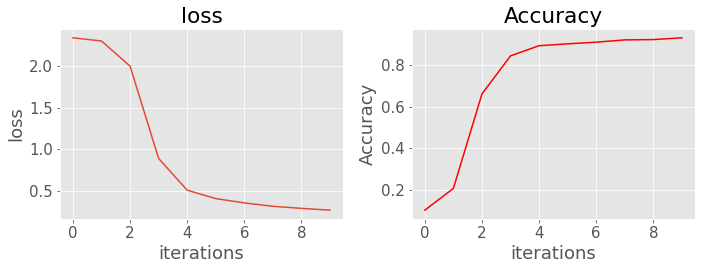

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 15
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1, 2, 1)   
ax1.plot(cnn.loss_list)
ax1.set_title('loss')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')

ax2 = fig.add_subplot(1, 2, 2)  
ax2.plot(cnn.acc_list, color='red')
ax2.set_title('Accuracy')
ax2.set_xlabel('iterations')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()